## Demo notebook for accessing Harmonized Global Biomass data on Azure

This notebook provides an example of accessing the Harmonized Global Biomass (HGB) data from blob storage on Azure, including (1) looking at the directory where data is stored, (2) loading the cloud optimized geotiff for a particular year, and (3) doing some simple processing and plotting of the data.

HGB data are stored in the West Europe Azure region, so this notebook will run most efficiently on Azure compute located in West Europe.  We recommend that substantial computation depending on HGB data also be situated in West Europe.  You don't want to download hundreds of terabytes to your laptop!  If you are using HGB data for environmental science applications, consider applying for an [AI for Earth grant](http://aka.ms/ai4egrants) to support your compute requirements.

### Imports and constants

In [1]:
import fsspec
import xarray as xr
import matplotlib.pyplot as plt 

storage_account_name = 'cpdataeuwest'
container = 'cpdata'
folder = 'raw/2010-harmonized-biomass/global/300m'

### View available data

In [2]:
fs = fsspec.get_filesystem_class('az')(account_name=storage_account_name)
fs.ls(path=f'{container}' + '/' + folder)

['cpdata/raw/2010-harmonized-biomass/global/300m/aboveground.tif',
 'cpdata/raw/2010-harmonized-biomass/global/300m/aboveground_uncertainty.tif',
 'cpdata/raw/2010-harmonized-biomass/global/300m/belowground.tif',
 'cpdata/raw/2010-harmonized-biomass/global/300m/belowground_uncertainty.tif']

In [3]:
# Load data for aboveground biomass
da = xr.open_rasterio(f'https://{storage_account_name}.blob.core.windows.net/' +
                      f'{container}' + '/' + folder + '/aboveground.tif', 
                      chunks=dict(x=2560, y=2560))

# Transform our data array to a dataset by selecting the only data variable ('band')
# renaming it to something useful ('biomass')
ds = da.to_dataset(dim='band').rename({1: 'biomass'})
ds

<xarray.Dataset>
Dimensions:  (x: 129600, y: 52201)
Coordinates:
  * y        (y) float64 84.0 84.0 83.99 83.99 ... -60.99 -61.0 -61.0 -61.0
  * x        (x) float64 -180.0 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0 180.0
Data variables:
    biomass  (y, x) uint16 dask.array<chunksize=(2560, 2560), meta=np.ndarray>
Attributes:
    transform:           (0.00277777777777778, 0.0, -180.00000000000006, 0.0,...
    crs:                 +init=epsg:4326
    res:                 (0.00277777777777778, 0.00277777777777778)
    is_tiled:            1
    nodatavals:          (nan,)
    scales:              (1.0,)
    offsets:             (0.0,)
    AREA_OR_POINT:       Area
    DataType:            Generic
    OVR_RESAMPLING_ALG:  NEAREST

### Plot global aboveground biomass

In [4]:
# Coarsen by 100x on each dimension to get to a reasonable plotting size 
factor = 100
coarse = ds.biomass.coarsen(dim={'x': factor, 'y': factor}, boundary='trim').mean().compute()

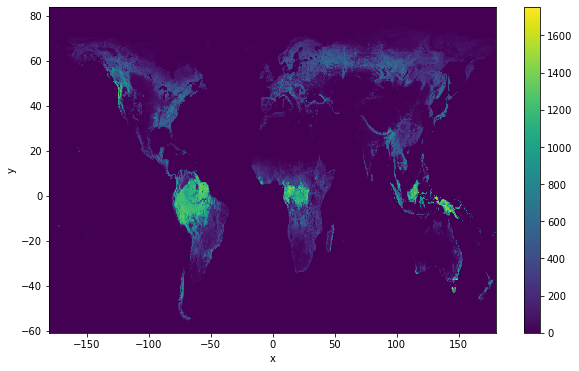

In [5]:
plt.figure(figsize=(10,6))
coarse.plot()
plt.show()